<a href="https://colab.research.google.com/github/snaily16/GAN-Implementations-Pytorch/blob/master/CGAN/ConditionalGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-926adb9a-c30e-55ab-55f7-7a4572c556e8)


In [2]:
%matplotlib inline

import time, os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools, pickle, imageio
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image
from torchsummary import summary

## Reference code : TeeyoHuang Git code [link text](https://github.com/TeeyoHuang/conditional-GAN)

In [3]:
!git clone https://github.com/TeeyoHuang/conditional-GAN

Cloning into 'conditional-GAN'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), done.


Set Hyperparameters

In [5]:
# Hyperparameters
batch_size=128
num_epochs=50
image_size=28
stats = (0.5), (0.5)
latent_size=100
n_classes=10
lr = 0.0002
b1 = 0.5
b2=0.999
channels=1
img_shape = (channels, image_size, image_size)

In [6]:
# Device configuration
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda' if cuda else 'cpu')

## Load Dataset

In [7]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
])

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_data, batch_size=batch_size ,shuffle=True, drop_last=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
# results save folder
if not os.path.isdir('MNIST_cGAN_results'):
    os.mkdir('MNIST_cGAN_results')

In [9]:
def normal_init(m, mean, std):
  if isinstance(m, nn.Linear):
    m.weight.data.normal_(mean, std)
    m.bias.data.zero_()

## Generator Network

In [10]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.fc1_1 = nn.Linear(latent_size, 256)
    self.bn1_1 = nn.BatchNorm1d(256)
    self.fc1_2 = nn.Linear(n_classes, 256)
    self.bn1_2 = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(512,512)
    self.bn2 = nn.BatchNorm1d(512)
    self.fc3 = nn.Linear(512,1024)
    self.bn3 = nn.BatchNorm1d(1024)
    self.fc4 = nn.Linear(1024,np.prod(img_shape))

  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  def forward(self, z, label):
    x = F.relu(self.bn1_1(self.fc1_1(z)))
    y = F.relu(self.bn1_2(self.fc1_2(label)))
    x = torch.cat([x,y],1)
    x = F.relu(self.bn2(self.fc2(x)))
    x = F.relu(self.bn3(self.fc3(x)))
    x = F.tanh(self.fc4(x))
    return x

In [11]:
G = Generator()
G.weight_init(mean=0, std=0.02)
G.to(device)
print(G)
#summary(G,[(1,28,28),()])

Generator(
  (fc1_1): Linear(in_features=100, out_features=256, bias=True)
  (bn1_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_2): Linear(in_features=10, out_features=256, bias=True)
  (bn1_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)


## Discriminator Network

In [12]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.fc1_1 = nn.Linear(np.prod(img_shape), 1024)
    self.fc1_2 = nn.Linear(n_classes, 1024)
    self.fc2 = nn.Linear(2048,512)
    self.bn2 = nn.BatchNorm1d(512)
    self.fc3 = nn.Linear(512,256)
    self.bn3 = nn.BatchNorm1d(256)
    self.fc4 = nn.Linear(256,1)

  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  def forward(self, input, label):
    x = F.leaky_relu(self.fc1_1(input.view(input.size(0),-1)), 0.2)
    y = F.leaky_relu(self.fc1_2(label), 0.2)
    x = torch.cat([x,y], 1)
    x = F.leaky_relu(self.bn2(self.fc2(x)), 0.2)
    x = F.leaky_relu(self.bn3(self.fc3(x)), 0.2)
    x = F.sigmoid(self.fc4(x))
    return x

In [13]:
D = Discriminator()
D.to(device)
print(D)
#summary(D,[(1,28,28),(1,10)])

Discriminator(
  (fc1_1): Linear(in_features=784, out_features=1024, bias=True)
  (fc1_2): Linear(in_features=10, out_features=1024, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


## Loss function and Optimizers

In [14]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(b1, b2))
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))

## Helper functions

In [15]:
noise = Variable(torch.FloatTensor(np.random.normal(0, 1, (n_classes**2, latent_size))).to(device))
#fixed labels
y_ = torch.LongTensor(np.array([num for num in range(n_classes)])).view(n_classes,1).expand(-1,n_classes).contiguous()
y_fixed = torch.zeros(n_classes**2, n_classes)
y_fixed = Variable(y_fixed.scatter_(1,y_.view(n_classes**2,1),1).cuda())

print(noise.shape, y_fixed.shape)

torch.Size([100, 100]) torch.Size([100, 10])


In [16]:
def generate_random_latent():
  return Variable(torch.rand(batch_size,latent_size).to(device))

def generate_random_labels():
  label = (torch.rand(batch_size, 1)*n_classes).type(torch.LongTensor)
  y = torch.zeros(batch_size,n_classes)
  return Variable(y.scatter_(1, label.view(batch_size, 1),1).to(device))

## Training functions

In [17]:
def train_discriminator(images, labels):
  # create labels
  mini_batch = images.shape[0]
  real_labels = Variable(torch.ones(mini_batch).to(device), requires_grad=False)
  fake_labels = Variable(torch.zeros(batch_size).to(device), requires_grad=False)
    
  # ============================
  #   Train the discriminator
  # ============================

  # Compute BCELoss using real images
  # where BCE_Loss(x, y): - y * log(D(x,y)) - (1-y) * log(1 - D(x,y))
  # Second term of the loss is always zero since real_labels == 1

  x = Variable(images.to(device))
  #x = Variable(images.view(images.size(0),-1))
  #y = torch.zeros(mini_batch, 10)
  #y.scatter_(1, labels.view(mini_batch, 1), 1)
  #y = Variable(y.to(device))
  
  outputs = D(x, labels).squeeze()
  d_real_loss = criterion(outputs, real_labels)
  real_score = outputs

  # compute BCELoss using fake images
  # First term of the loss is always zero since fake_labels == 0
  z = generate_random_latent()
  gen_y = generate_random_labels()

  fake_images = G(z, gen_y)
  outputs = D(fake_images, gen_y).squeeze()
  d_fake_loss = criterion(outputs, fake_labels)
  fake_score = outputs

  # Backprop and optimize
  d_loss = d_real_loss + d_fake_loss
  d_optimizer.zero_grad()
  d_loss.backward()
  d_optimizer.step()

  return d_loss, real_score, fake_score

In [18]:
def train_generator():
  real_labels = Variable(torch.ones(batch_size).to(device))
  
  # ============================
  #    Train the Generator
  # ============================
    
  # compute loss with fake image
  z = generate_random_latent()
  gen_y = generate_random_labels()
  gen_images = G(z, gen_y)
  outputs = D(gen_images, gen_y)

  # train G to maximize log(D(G(z)))
  g_loss = criterion(outputs, real_labels)

  # Backprop and optimize
  g_optimizer.zero_grad()
  g_loss.backward()
  g_optimizer.step()
  
  return g_loss, gen_images

In [19]:
for images,labels in tqdm(train_loader):
  print(images.shape, labels.shape)
  onehotVec = torch.zeros(batch_size, n_classes)
  onehotVec = Variable(onehotVec.scatter_(1,labels.view(batch_size,1),1).to(device))
  print(onehotVec.shape)
  break

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])


In [20]:
# Start Training
batches_done =0
d_losses, g_losses, real_scores, fake_scores =[],[],[],[]
path = 'MNIST_cGAN_results'
total_batches = len(train_loader)-1

for epoch in range(num_epochs):
  D_loss, G_loss = [], []
  epoch_start_time = time.time()
  for images,labels in tqdm(train_loader):
    #images = images.reshape(batch_size, -1).to(device)
    real_imgs = Variable(images.type(torch.FloatTensor))
    #labels = Variable(labels.type(torch.LongTensor))
    onehotVec = torch.zeros(batch_size, n_classes)
    onehotVec = Variable(onehotVec.scatter_(1,labels.view(batch_size,1),1).to(device))

    d_loss, real_score, fake_score = train_discriminator(real_imgs,onehotVec)
    g_loss, fake_images = train_generator()

    if batches_done%(total_batches//2)==0:
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())
      real_scores.append(real_score.mean().item())
      fake_scores.append(fake_score.mean().item())

      gen_imgs = G(noise, y_fixed).view(-1,channels,image_size,image_size)
      save_image(gen_imgs.data, path+ '/%d%d.png' % (epoch,batches_done), nrow=n_classes, normalize=True)
      print("Epochs: [%d/%d], Steps: [%d], d_loss: %.3f, g_loss: %.3f" % 
            (epoch+1, num_epochs, batches_done+1, d_loss.item(), g_loss.item()))
    batches_done+=1
  

torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epochs: [1/50], Steps: [1], d_loss: 1.407, g_loss: 0.707
Epochs: [1/50], Steps: [234], d_loss: 1.247, g_loss: 0.831
Epochs: [1/50], Steps: [467], d_loss: 1.189, g_loss: 0.901



Epochs: [2/50], Steps: [700], d_loss: 1.157, g_loss: 0.892
Epochs: [2/50], Steps: [933], d_loss: 1.151, g_loss: 0.927



Epochs: [3/50], Steps: [1166], d_loss: 1.140, g_loss: 0.967
Epochs: [3/50], Steps: [1399], d_loss: 1.144, g_loss: 0.969



Epochs: [4/50], Steps: [1632], d_loss: 1.146, g_loss: 0.979
Epochs: [4/50], Steps: [1865], d_loss: 1.139, g_loss: 0.999



Epochs: [5/50], Steps: [2098], d_loss: 1.138, g_loss: 1.028
Epochs: [5/50], Steps: [2331], d_loss: 1.137, g_loss: 1.017



Epochs: [6/50], Steps: [2564], d_loss: 1.126, g_loss: 1.009
Epochs: [6/50], Steps: [2797], d_loss: 1.127, g_loss: 1.013



Epochs: [7/50], Steps: [3030], d_loss: 1.078, g_loss: 1.088
Epochs: [7/50], Steps: [3263], d_loss: 1.056, g_loss: 1.129



Epochs: [8/50], Steps: [3496], d_loss: 1.041, g_loss: 1.188
Epochs: [8/50], Steps: [3729], d_loss: 1.025, g_loss: 1.216



Epochs: [9/50], Steps: [3962], d_loss: 1.013, g_loss: 1.229
Epochs: [9/50], Steps: [4195], d_loss: 1.026, g_loss: 1.207



Epochs: [10/50], Steps: [4428], d_loss: 1.029, g_loss: 1.198
Epochs: [10/50], Steps: [4661], d_loss: 1.027, g_loss: 1.206



Epochs: [11/50], Steps: [4894], d_loss: 1.036, g_loss: 1.208
Epochs: [11/50], Steps: [5127], d_loss: 1.034, g_loss: 1.213



Epochs: [12/50], Steps: [5360], d_loss: 1.034, g_loss: 1.207
Epochs: [12/50], Steps: [5593], d_loss: 1.020, g_loss: 1.199



Epochs: [13/50], Steps: [5826], d_loss: 1.037, g_loss: 1.185
Epochs: [13/50], Steps: [6059], d_loss: 1.040, g_loss: 1.169



Epochs: [14/50], Steps: [6292], d_loss: 1.048, g_loss: 1.158
Epochs: [14/50], Steps: [6525], d_loss: 1.044, g_loss: 1.161



Epochs: [15/50], Steps: [6758], d_loss: 1.039, g_loss: 1.169
Epochs: [15/50], Steps: [6991], d_loss: 1.045, g_loss: 1.171



Epochs: [16/50], Steps: [7224], d_loss: 1.037, g_loss: 1.171
Epochs: [16/50], Steps: [7457], d_loss: 1.025, g_loss: 1.186



Epochs: [17/50], Steps: [7690], d_loss: 1.014, g_loss: 1.189
Epochs: [17/50], Steps: [7923], d_loss: 0.995, g_loss: 1.192



Epochs: [18/50], Steps: [8156], d_loss: 1.005, g_loss: 1.187
Epochs: [18/50], Steps: [8389], d_loss: 0.984, g_loss: 1.216



Epochs: [19/50], Steps: [8622], d_loss: 0.980, g_loss: 1.233
Epochs: [19/50], Steps: [8855], d_loss: 0.961, g_loss: 1.284



Epochs: [20/50], Steps: [9088], d_loss: 0.959, g_loss: 1.292
Epochs: [20/50], Steps: [9321], d_loss: 0.947, g_loss: 1.302



Epochs: [21/50], Steps: [9554], d_loss: 0.927, g_loss: 1.325
Epochs: [21/50], Steps: [9787], d_loss: 0.912, g_loss: 1.359



Epochs: [22/50], Steps: [10020], d_loss: 0.901, g_loss: 1.391
Epochs: [22/50], Steps: [10253], d_loss: 0.894, g_loss: 1.379



Epochs: [23/50], Steps: [10486], d_loss: 0.879, g_loss: 1.404
Epochs: [23/50], Steps: [10719], d_loss: 0.871, g_loss: 1.409



Epochs: [24/50], Steps: [10952], d_loss: 0.865, g_loss: 1.411
Epochs: [24/50], Steps: [11185], d_loss: 0.866, g_loss: 1.416



Epochs: [25/50], Steps: [11418], d_loss: 0.858, g_loss: 1.442
Epochs: [25/50], Steps: [11651], d_loss: 0.849, g_loss: 1.455



Epochs: [26/50], Steps: [11884], d_loss: 0.852, g_loss: 1.453
Epochs: [26/50], Steps: [12117], d_loss: 0.840, g_loss: 1.474



Epochs: [27/50], Steps: [12350], d_loss: 0.829, g_loss: 1.506
Epochs: [27/50], Steps: [12583], d_loss: 0.817, g_loss: 1.521



Epochs: [28/50], Steps: [12816], d_loss: 0.818, g_loss: 1.521
Epochs: [28/50], Steps: [13049], d_loss: 0.814, g_loss: 1.523



Epochs: [29/50], Steps: [13282], d_loss: 0.819, g_loss: 1.524
Epochs: [29/50], Steps: [13515], d_loss: 0.811, g_loss: 1.522



Epochs: [30/50], Steps: [13748], d_loss: 0.815, g_loss: 1.532
Epochs: [30/50], Steps: [13981], d_loss: 0.806, g_loss: 1.545



Epochs: [31/50], Steps: [14214], d_loss: 0.806, g_loss: 1.539
Epochs: [31/50], Steps: [14447], d_loss: 0.815, g_loss: 1.529



Epochs: [32/50], Steps: [14680], d_loss: 0.818, g_loss: 1.519
Epochs: [32/50], Steps: [14913], d_loss: 0.810, g_loss: 1.514



Epochs: [33/50], Steps: [15146], d_loss: 0.800, g_loss: 1.527
Epochs: [33/50], Steps: [15379], d_loss: 0.804, g_loss: 1.558



Epochs: [34/50], Steps: [15612], d_loss: 0.798, g_loss: 1.556
Epochs: [34/50], Steps: [15845], d_loss: 0.791, g_loss: 1.555



Epochs: [35/50], Steps: [16078], d_loss: 0.785, g_loss: 1.564
Epochs: [35/50], Steps: [16311], d_loss: 0.777, g_loss: 1.584



Epochs: [36/50], Steps: [16544], d_loss: 0.771, g_loss: 1.597
Epochs: [36/50], Steps: [16777], d_loss: 0.766, g_loss: 1.595



Epochs: [37/50], Steps: [17010], d_loss: 0.759, g_loss: 1.595
Epochs: [37/50], Steps: [17243], d_loss: 0.753, g_loss: 1.607



Epochs: [38/50], Steps: [17476], d_loss: 0.753, g_loss: 1.614
Epochs: [38/50], Steps: [17709], d_loss: 0.750, g_loss: 1.617



Epochs: [39/50], Steps: [17942], d_loss: 0.745, g_loss: 1.636
Epochs: [39/50], Steps: [18175], d_loss: 0.752, g_loss: 1.646



Epochs: [40/50], Steps: [18408], d_loss: 0.749, g_loss: 1.647
Epochs: [40/50], Steps: [18641], d_loss: 0.744, g_loss: 1.642



Epochs: [41/50], Steps: [18874], d_loss: 0.743, g_loss: 1.639
Epochs: [41/50], Steps: [19107], d_loss: 0.741, g_loss: 1.634



Epochs: [42/50], Steps: [19340], d_loss: 0.733, g_loss: 1.631
Epochs: [42/50], Steps: [19573], d_loss: 0.727, g_loss: 1.634



Epochs: [43/50], Steps: [19806], d_loss: 0.722, g_loss: 1.659
Epochs: [43/50], Steps: [20039], d_loss: 0.717, g_loss: 1.648



Epochs: [44/50], Steps: [20272], d_loss: 0.716, g_loss: 1.651
Epochs: [44/50], Steps: [20505], d_loss: 0.716, g_loss: 1.644



Epochs: [45/50], Steps: [20738], d_loss: 0.716, g_loss: 1.646
Epochs: [45/50], Steps: [20971], d_loss: 0.711, g_loss: 1.649



Epochs: [46/50], Steps: [21204], d_loss: 0.705, g_loss: 1.656
Epochs: [46/50], Steps: [21437], d_loss: 0.699, g_loss: 1.665



Epochs: [47/50], Steps: [21670], d_loss: 0.695, g_loss: 1.687
Epochs: [47/50], Steps: [21903], d_loss: 0.696, g_loss: 1.684



Epochs: [48/50], Steps: [22136], d_loss: 0.697, g_loss: 1.684
Epochs: [48/50], Steps: [22369], d_loss: 0.720, g_loss: 1.682



Epochs: [49/50], Steps: [22602], d_loss: 0.714, g_loss: 1.698
Epochs: [49/50], Steps: [22835], d_loss: 0.712, g_loss: 1.689



Epochs: [50/50], Steps: [23068], d_loss: 0.706, g_loss: 1.694
Epochs: [50/50], Steps: [23301], d_loss: 0.706, g_loss: 1.706



Text(0.5, 1.0, 'Training Losses')

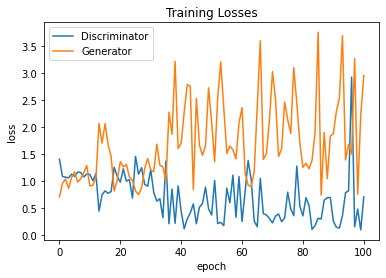

In [21]:
# plot loss
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Training Losses')

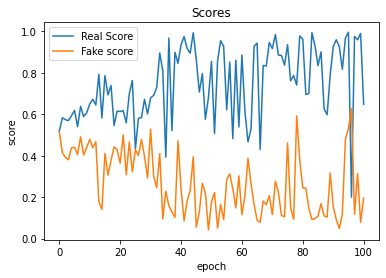

In [23]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [24]:
png_dir = 'MNIST_cGAN_results/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('demo.gif', images,fps=3)